<a href="https://colab.research.google.com/github/p1306/Leaf-Analysis-Project/blob/main/Project1(Potato_Pepper).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ImageSize = 256
BatchSize = 32
channels = 3
epochs = 20

In [ ]:
data = tf.keras.preprocessing.image_dataset_from_directory(
        "/content/drive/MyDrive/PlantVillage/Potato_images",
        shuffle=True,
        image_size=(ImageSize, ImageSize),
        batch_size=BatchSize
)

Found 1210 files belonging to 3 classes.


In [ ]:
class_names = data.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
for image_batch, labels_batch in data.take(1):
      print(image_batch.shape)
      print(labels_batch.numpy())

(32, 256, 256, 3)
[0 1 0 1 1 0 0 2 1 1 2 1 1 1 0 1 0 2 1 2 1 0 0 1 2 0 0 1 0 0 0 0]


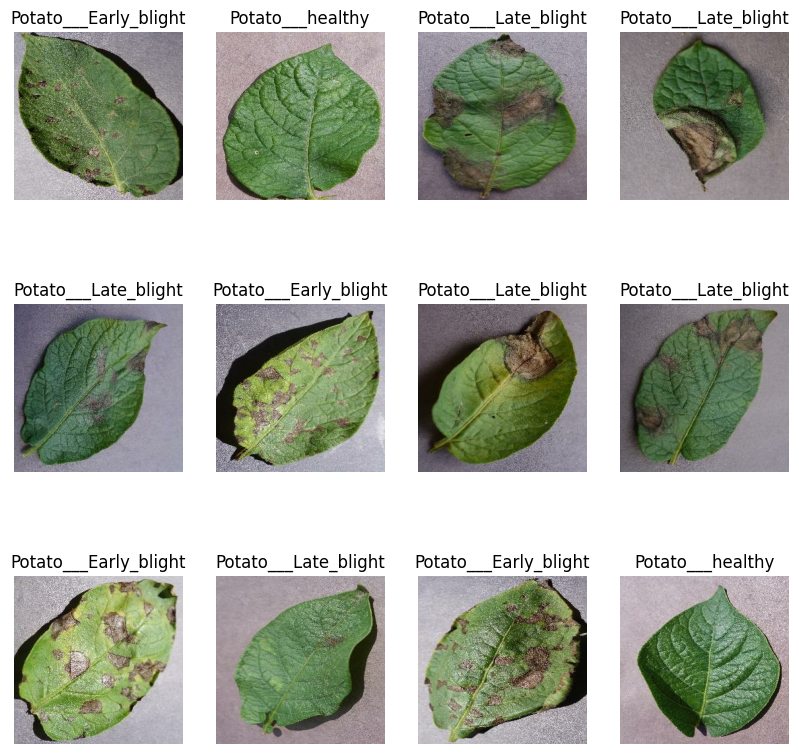

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in data.take(1):
    for i in range(12):
            ax = plt.subplot(3, 4, i + 1)
            plt.imshow(image_batch[i].numpy().astype("uint8"))
            plt.title(class_names[labels_batch[i]])
            plt.axis("off")

In [ ]:
train_size = 0.8
len(data)*train_size

30.400000000000002

In [ ]:
train_data = data.take(30)
len(train_data)

30

In [ ]:
test = data.skip(30)
len(test)

8

In [ ]:
val_size = 0.1
len(data)*val_size

3.8000000000000003

In [ ]:
val_data = test.take(4)
len(val_data)

4

In [ ]:
test_data = test.skip(4)
len(test_data)

4

In [ ]:
def train_test_split(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
      assert (train_split + test_split + val_split) == 1

      ds_size = len(ds)

      if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

      train_size = int(train_split * ds_size)
      val_size = int(val_split * ds_size)

      train_ds = ds.take(train_size)
      val_ds = ds.skip(train_size).take(val_size)
      test_ds = ds.skip(train_size).skip(val_size)

      return train_ds, val_ds, test_ds

In [ ]:
train_data, val_data, test_data = train_test_split(data)

In [ ]:
print(len(train_data), len(val_data), len(test_data))

30 3 5


In [ ]:
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
      layers.Resizing(ImageSize, ImageSize),
      layers.Rescaling(1.0 / 255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
      layers.RandomFlip("horizontal_and_vertical"),
      layers.RandomRotation(0.2)
])

In [ ]:
train_data = train_data.map(
      lambda x, y: (data_augmentation(x, training=True), y)
      ).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
input_shape = (BatchSize, ImageSize, ImageSize, channels)
n_classes = 3

model = models.Sequential([
    layers.Input(shape=(ImageSize, ImageSize, channels)),
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

In [ ]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
      optimizer='adam',
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
      metrics=['accuracy']
)

In [ ]:
history = model.fit(
      train_data,
      batch_size=BatchSize,
      validation_data=val_data,
      verbose=1,
      epochs=20,
)

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 172s 6s/step - accuracy: 0.9593 - loss: 0.1222 - val_accuracy: 0.9896 - val_loss: 0.0710
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 144s 5s/step - accuracy: 0.9517 - loss: 0.1449 - val_accuracy: 0.9583 - val_loss: 0.0758
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 145s 5s/step - accuracy: 0.9470 - loss: 0.1439 - val_accuracy: 0.9792 - val_loss: 0.0977
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 143s 5s/step - accuracy: 0.9556 - loss: 0.1192 - val_accuracy: 0.9688 - val_loss: 0.0870
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 154s 5s/step - accuracy: 0.9514 - loss: 0.1386 - val_accuracy: 0.8958 - val_loss: 0.2515
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 144s 5s/step - accuracy: 0.9353 - loss: 0.1641 - val_accuracy: 0.9896 - val_loss: 0.0485
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 147s 5s/step - accuracy: 0.9611 - loss: 0.1266 - val_accuracy: 0.9896 - val_loss: 0.0507
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 198s 5s/step - accuracy: 0.9667 - loss: 0.0973 - val_accuracy: 1.0000 - v

In [ ]:
scores = model.evaluate(test_data)

5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9707 - loss: 0.0698


In [ ]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 30}

In [ ]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.14362658560276031,
 0.12278424203395844,
 0.14476102590560913,
 0.12907494604587555,
 0.12290488183498383]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

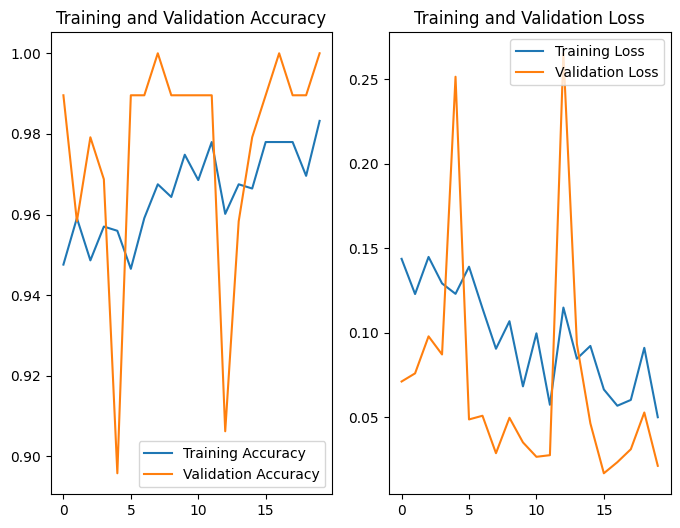

In [ ]:
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
import numpy as np
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


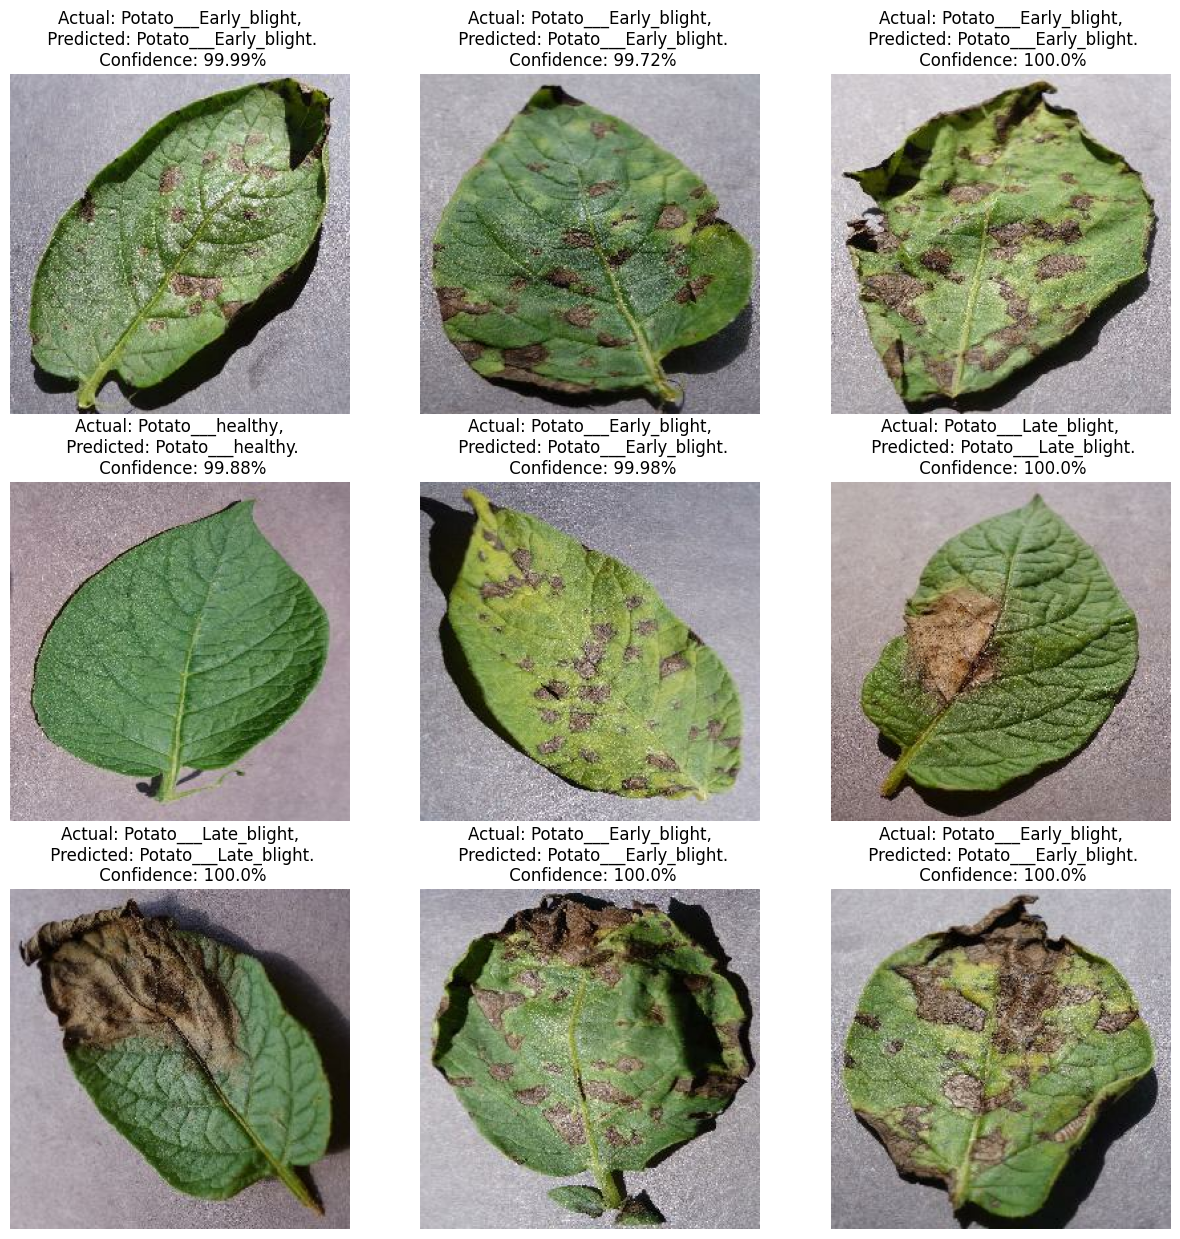

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_data.take(1):
    for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))

            predicted_class, confidence = predict(model, images[i].numpy())
            actual_class = class_names[labels[i]]

            plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

            plt.axis("off")

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.9716 - loss: 0.0761
Test Accuracy: 98.12%


In [ ]:
# Confusion Matrix
y_true = []
y_pred = []

for images, labels in test_data:
    y_true.extend(labels.numpy())
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))

conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", conf_matrix)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Confusion Matrix:
 [[72  0  0]
 [ 3 66  0]
 [ 0  0 19]]


In [ ]:
# Classification Report
class_report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n", class_report)

Classification Report:
                        precision    recall  f1-score   support

Potato___Early_blight       0.96      1.00      0.98        72
 Potato___Late_blight       1.00      0.96      0.98        69
     Potato___healthy       1.00      1.00      1.00        19

             accuracy                           0.98       160
            macro avg       0.99      0.99      0.99       160
         weighted avg       0.98      0.98      0.98       160



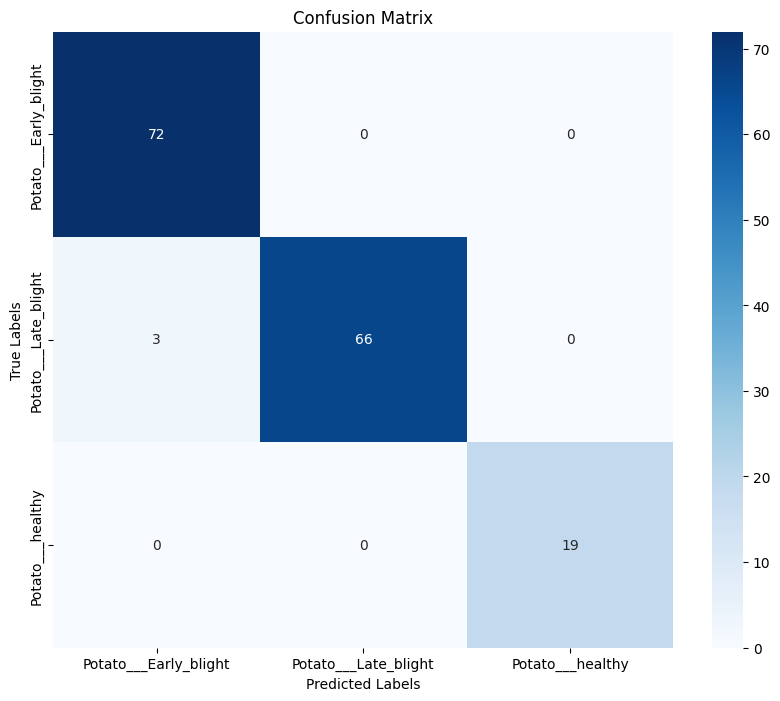

In [ ]:
# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

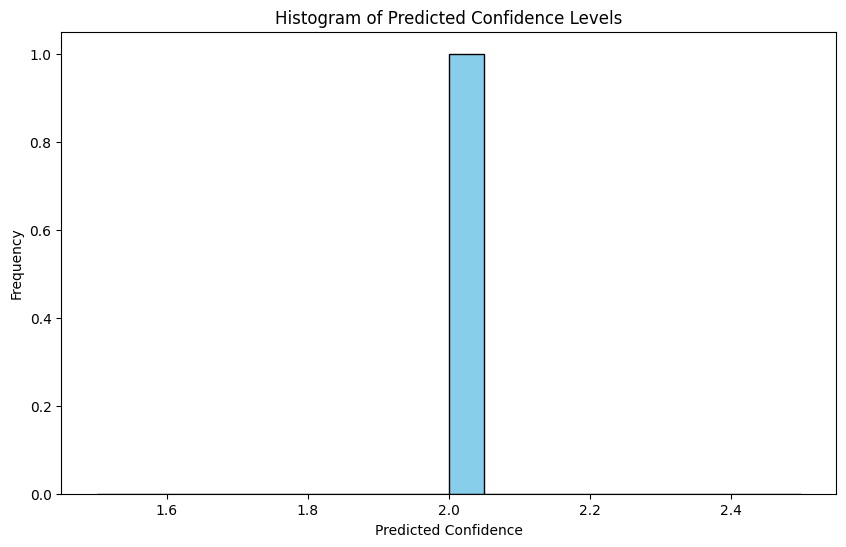

In [ ]:
plt.figure(figsize=(10, 6))
predicted_confidences = np.max(y_pred, axis=0)
plt.hist(predicted_confidences, bins=20, color='skyblue', edgecolor='black')
plt.xlabel("Predicted Confidence")
plt.ylabel("Frequency")
plt.title("Histogram of Predicted Confidence Levels")
plt.show()

**Pepper Bell**

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ImageSize = 256
BatchSize = 32
channels = 3
epochs = 20

In [ ]:
data = tf.keras.preprocessing.image_dataset_from_directory(
        "/content/drive/MyDrive/PlantVillage/Pepper_images",
        shuffle=True,
        image_size=(ImageSize, ImageSize),
        batch_size=BatchSize
)

Found 1658 files belonging to 2 classes.


In [ ]:
class_names = data.class_names
class_names

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']

In [ ]:
for image_batch, labels_batch in data.take(1):
      print(image_batch.shape)
      print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 0 1 0 1 1 1 1 1 0 0 0 0 1 1 1 0 0 0 0 1 1 1 1 1 0 0 1 1 1 0]


ValueError: num must be an integer with 1 <= num <= 9, not 10

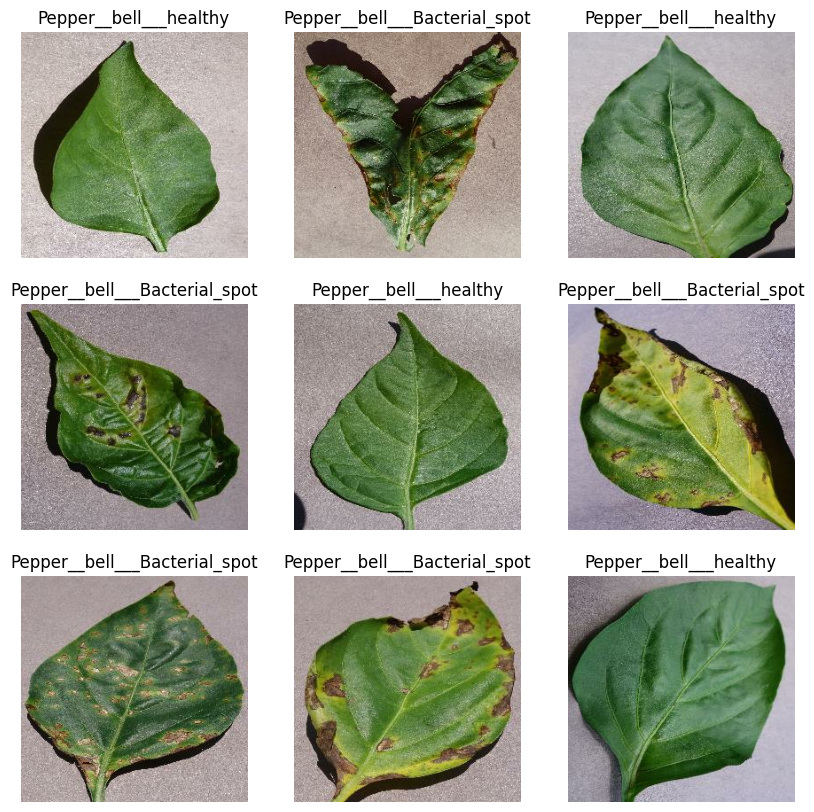

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in data.take(1):
    for i in range(12):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(image_batch[i].numpy().astype("uint8"))
            plt.title(class_names[labels_batch[i]])
            plt.axis("off")

In [ ]:
train_size = 0.8
len(data)*train_size

41.6

In [ ]:
train_data = data.take(30)
len(train_data)

30

In [ ]:
test = data.skip(30)
len(test)

22

In [ ]:
val_size = 0.1
len(data)*val_size
val_data = test.take(4)
len(val_data)

4

In [ ]:
test_data = test.skip(4)
len(test_data)

18

In [ ]:
def train_test_split(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
      assert (train_split + test_split + val_split) == 1

      ds_size = len(ds)

      if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

      train_size = int(train_split * ds_size)
      val_size = int(val_split * ds_size)

      train_ds = ds.take(train_size)
      val_ds = ds.skip(train_size).take(val_size)
      test_ds = ds.skip(train_size).skip(val_size)

      return train_ds, val_ds, test_ds

In [ ]:
train_data, val_data, test_data = train_test_split(data)
print(len(train_data), len(val_data), len(test_data))

41 5 6


In [ ]:
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
      layers.Resizing(ImageSize, ImageSize),
      layers.Rescaling(1.0 / 255)
])
data_augmentation = tf.keras.Sequential([
      layers.RandomFlip("horizontal_and_vertical"),
      layers.RandomRotation(0.2)
])

In [ ]:
train_data = train_data.map(
      lambda x, y: (data_augmentation(x, training=True), y)
      ).prefetch(buffer_size=tf.data.AUTOTUNE)
input_shape = (BatchSize, ImageSize, ImageSize, channels)
n_classes = 3

In [ ]:
model = models.Sequential([
    layers.Input(shape=(ImageSize, ImageSize, channels)),
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

In [ ]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
      optimizer='adam',
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
      metrics=['accuracy']
)

In [ ]:
history = model.fit(
      train_data,
      batch_size=BatchSize,
      validation_data=val_data,
      verbose=1,
      epochs=20,
)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 343s 5s/step - accuracy: 0.5084 - loss: 0.8068 - val_accuracy: 0.6375 - val_loss: 0.6112
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 200s 5s/step - accuracy: 0.7179 - loss: 0.5581 - val_accuracy: 0.8188 - val_loss: 0.3754
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 196s 5s/step - accuracy: 0.8834 - loss: 0.3005 - val_accuracy: 0.8625 - val_loss: 0.2791
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 193s 5s/step - accuracy: 0.9371 - loss: 0.2230 - val_accuracy: 0.9438 - val_loss: 0.1578
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 194s 5s/step - accuracy: 0.9453 - loss: 0.2012 - val_accuracy: 0.9750 - val_loss: 0.0598
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 193s 5s/step - accuracy: 0.9748 - loss: 0.0738 - val_accuracy: 0.9875 - val_loss: 0.0483
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 193s 5s/step - accuracy: 0.9781 - loss: 0.0637 - val_accuracy: 0.9937 - val_loss: 0.0218
Epoch 8/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 202s 5s/step - accuracy: 0.9871 - loss: 0.0532 - val_accuracy: 1.0000 - v

In [ ]:
scores = model.evaluate(test_data)
history.params
history.history['loss'][:5] # show loss for first 5 epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.9543 - loss: 0.0824


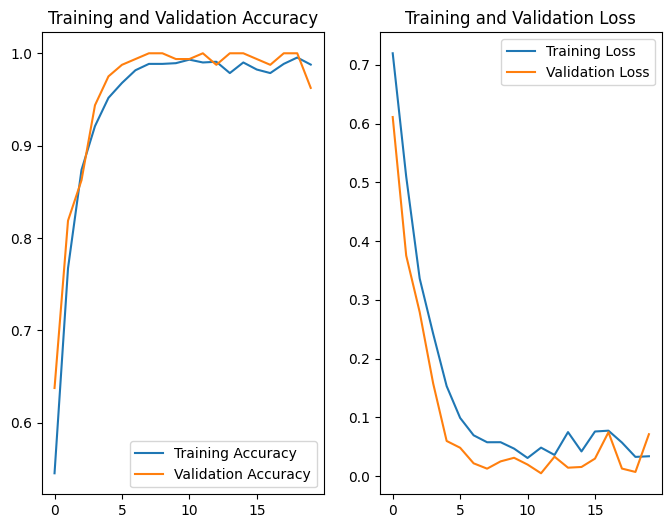

In [ ]:
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


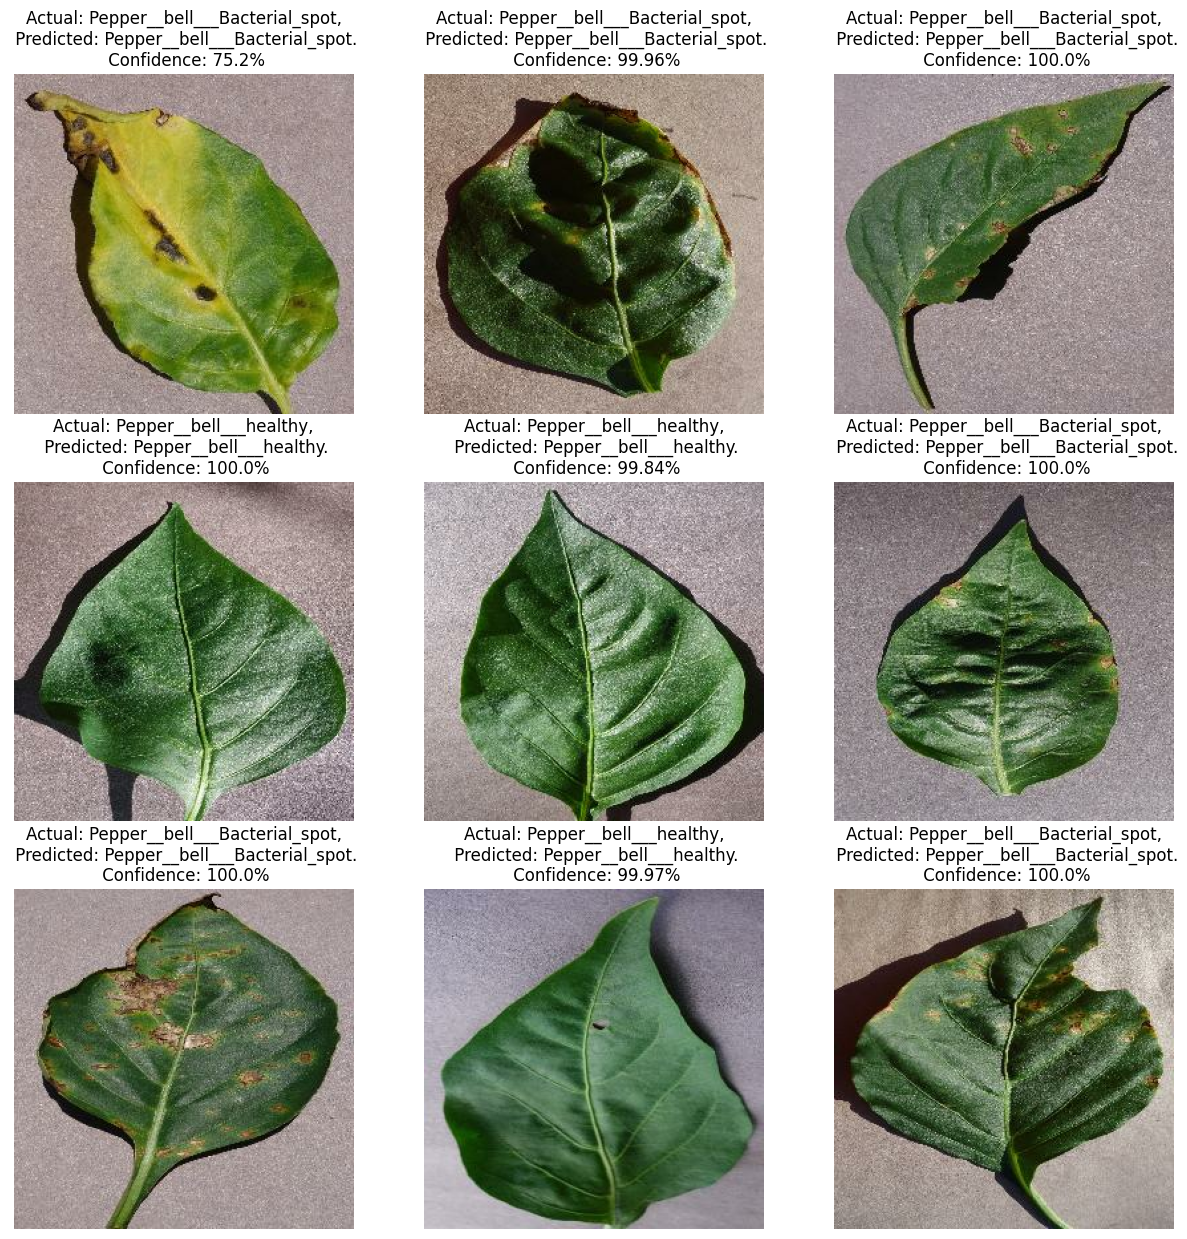

In [ ]:
import numpy as np
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence
plt.figure(figsize=(15, 15))
for images, labels in test_data.take(1):
    for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))

            predicted_class, confidence = predict(model, images[i].numpy())
            actual_class = class_names[labels[i]]

            plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

            plt.axis("off")

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9482 - loss: 0.1022
Test Accuracy: 94.79%


In [ ]:
# Confusion Matrix
y_true = []
y_pred = []

for images, labels in test_data:
    y_true.extend(labels.numpy())
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))

conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", conf_matrix)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Confusion Matrix:
 [[ 81  10]
 [  0 101]]


In [ ]:
# Classification Report
class_report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n", class_report)

Classification Report:
                                precision    recall  f1-score   support

Pepper__bell___Bacterial_spot       1.00      0.89      0.94        91
       Pepper__bell___healthy       0.91      1.00      0.95       101

                     accuracy                           0.95       192
                    macro avg       0.95      0.95      0.95       192
                 weighted avg       0.95      0.95      0.95       192



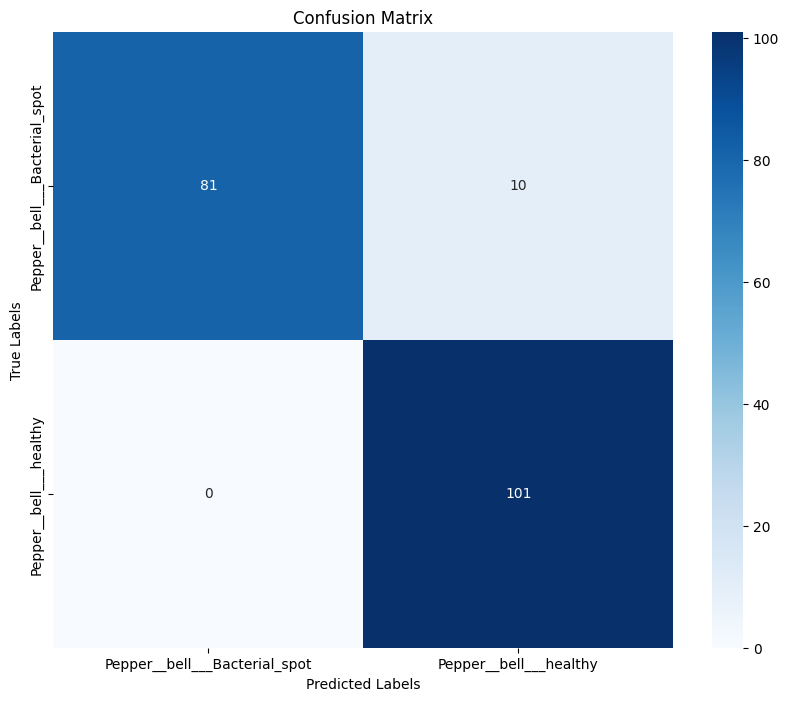

In [ ]:
# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

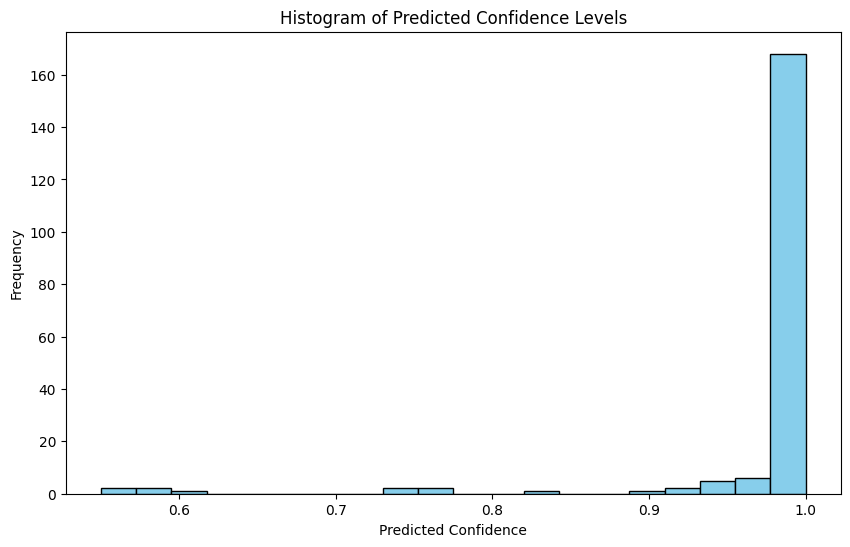

In [ ]:
plt.figure(figsize=(10, 6))
predicted_confidences = np.max(y_pred_probs, axis=1)
plt.hist(predicted_confidences, bins=20, color='skyblue', edgecolor='black')
plt.xlabel("Predicted Confidence")
plt.ylabel("Frequency")
plt.title("Histogram of Predicted Confidence Levels")
plt.show()